# P_bar globe, based on P_bar deep dive

Need to try this coord interp again, but with the methods that seem promising from P_bar deep dive

## Housekeeping

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce
from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid
from tqdm.notebook import tqdm
from scipy.ndimage import uniform_filter1d

In [2]:
import os
os.chdir('/home/amf2288/argo-intern/funcs')
import filt_funcs as ff
import density_funcs as df

In [3]:
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize']  = 18
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

## Load pre-made datasets

In [9]:
#individual profiles where sampling rate <=2.5m, pressure grid
ds_p = xr.open_dataset('/swot/SUM05/amf2288/ds_p_copilot.nc')
ds_r = xr.open_dataset('/swot/SUM05/amf2288/ds_r_copilot.nc')
ds_pbar = xr.open_dataset('/swot/SUM05/amf2288/ds_pbar_copilot.nc').rename({'pmean_grid':'PRESSURE_mean'})

In [10]:
CL_p = xr.open_dataset('/swot/SUM05/amf2288/AMF_clim_p_copilot.nc')
CL_r = xr.open_dataset('/swot/SUM05/amf2288/AMF_clim_r_copilot.nc')

FileNotFoundError: [Errno 2] No such file or directory: '/swot/SUM05/amf2288/AMF_clim_p_copilot.nc'

## Sort by density and reindex (individual profiles)

In [6]:
def sorting_index_from_sig(sig):
    """
    sig0: 1D numpy array for a single profile.
    Returns: 1D array of indices (same length) that sorts the valid region
             and leaves NaNs at the edges.
    """
    valid = ~np.isnan(sig)

    if not np.any(valid):
        return np.arange(len(sig))  # nothing to sort

    # valid region boundaries
    i0 = np.argmax(valid)
    i1 = len(sig) - np.argmax(valid[::-1])

    # sorting index for the core region
    core = sig[i0:i1]
    core_sort_idx = np.argsort(core)

    # build full index array
    full_idx = np.arange(len(sig))
    full_idx[i0:i1] = full_idx[i0:i1][core_sort_idx]

    return full_idx

In [7]:
def apply_sort_index(var, sort_idx, dim="PRESSURE"):
    return xr.apply_ufunc(
        lambda v, idx: v[idx],
        var,
        sort_idx,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[dim]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[var.dtype],
    )

In [8]:
ds_sort_idx = xr.apply_ufunc(
    sorting_index_from_sig,
    ds_p["SIG0"],
    input_core_dims=[["PRESSURE"]],
    output_core_dims=[["PRESSURE"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[int],
)

In [9]:
ds_p["SIG0_sort"] = apply_sort_index(ds_p["SIG0"], ds_sort_idx)

In [10]:
#vars_to_sort = ["CT", "SA", "TEMP", "PSAL", "PRESSURE", "SPICE"]

vars_to_sort = ["CT", "SA", "SPICE", "PRESSURE"]

for v in vars_to_sort:
    ds_p[f"{v}_sort"] = apply_sort_index(ds_p[v], ds_sort_idx)

In [11]:
#plots to compare CT to CT_sort on the globe

## Sort by density (climatology)

In [12]:
CL_sort_idx = xr.apply_ufunc(
    sorting_index_from_sig,
    CL_p["SIG0"],
    input_core_dims=[["PRESSURE"]],
    output_core_dims=[["PRESSURE"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[int],
)

In [13]:
CL_p["SIG0_sort"] = apply_sort_index(CL_p["SIG0"], CL_sort_idx)

In [14]:
vars_to_sort = ["CT", "SA", "SPICE", "PRESSURE"]

for v in vars_to_sort:
    CL_p[f"{v}_sort"] = apply_sort_index(CL_p[v], CL_sort_idx)

## Create ds_r

In [15]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

In [16]:
def get_ds_rho(ds_z, da_SIG, rho_grid, variables, dim1='PROFILE', dim2='PRESSURE', RG_flag=False):

    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        # Determine output dtype - use float64 to handle NaN values from interpolation
        # Integer dtypes cannot represent NaN, which causes issues when extrapolate=False
        var_dtype = ds_z[var].dtype
        if np.issubdtype(var_dtype, np.integer):
            output_dtype = np.float64
        else:
            output_dtype = var_dtype
            
        var_interp = xr.apply_ufunc(interp_to_rho, da_SIG, ds_z[var],
            input_core_dims=[[dim2], [dim2]],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[output_dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=[dim1, 'rho_grid'],
            coords={'rho_grid': rho_grid, dim1: ds_z[dim1]},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')

    if RG_flag==False:
        ds_rho = ds_rho.assign_coords(LAT  =(dim1, ds_z.LAT.data))
        ds_rho = ds_rho.assign_coords(LON  =(dim1, ds_z.LON.data))
        ds_rho = ds_rho.assign_coords(TIME =(dim1, ds_z.TIME.data))
    
    return ds_rho

In [17]:
#again just doing CT for now, to see where we're at for method validation
variables = ['CT_sort','SA_sort','SPICE_sort','PRESSURE',"PRESSURE_sort"]
ds_r = get_ds_rho(ds_p, ds_p.SIG0_sort, np.arange(22,28,0.001), variables)

Completed comp for CT_sort
Completed CT_sort
Completed comp for SA_sort
Completed SA_sort
Completed comp for SPICE_sort
Completed SPICE_sort
Completed comp for PRESSURE
Completed PRESSURE
Completed comp for PRESSURE_sort
Completed PRESSURE_sort
Completed merge


In [18]:
ds_r = ds_r.rename({'rho_grid':'DENSITY'})

#### Need to convert CL_p to CL_r to preserve sorting, requires stacking and unstacking

In [19]:
CL_p_stacked = CL_p.stack(PROFILE=("LAT", "LON"))

pressure = CL_p_stacked.PRESSURE.data  # shape (1001,)
prof = CL_p_stacked.PROFILE.size      # number of profiles

# Repeat pressure along columns to get shape (1001, prof)
pressure_2d = np.repeat(pressure[:, np.newaxis], prof, axis=1)

# Add as a new variable with fresh name to avoid conflict
CL_p_stacked["PRESSURE"] = (("PRESSURE", "PROFILE"), pressure_2d)

In [20]:
CL_p_r_stacked = get_ds_rho(CL_p_stacked, CL_p_stacked.SIG0_sort, np.arange(22,28,0.001), ['CT_sort','SA_sort','SIG0_sort','SPICE_sort','PRESSURE','PRESSURE_sort'], RG_flag=True)

Completed comp for CT_sort
Completed CT_sort
Completed comp for SA_sort
Completed SA_sort
Completed comp for SIG0_sort
Completed SIG0_sort
Completed comp for SPICE_sort
Completed SPICE_sort
Completed comp for PRESSURE
Completed PRESSURE
Completed comp for PRESSURE_sort
Completed PRESSURE_sort
Completed merge


In [21]:
CL_r = CL_p_r_stacked.unstack('PROFILE').rename({'rho_grid':'DENSITY'})
CL_r

<xarray.Dataset> Size: 2GB
Dimensions:        (LAT: 60, LON: 120, DENSITY: 6000)
Coordinates:
  * LAT            (LAT) float64 480B -88.5 -85.5 -82.5 -79.5 ... 82.5 85.5 88.5
  * LON            (LON) float64 960B -178.5 -175.5 -172.5 ... 172.5 175.5 178.5
  * DENSITY        (DENSITY) float64 48kB 22.0 22.0 22.0 22.0 ... 28.0 28.0 28.0
Data variables:
    CT_sort        (DENSITY, LAT, LON) float64 346MB nan nan nan ... nan nan nan
    SA_sort        (DENSITY, LAT, LON) float64 346MB nan nan nan ... nan nan nan
    SIG0_sort      (DENSITY, LAT, LON) float64 346MB nan nan nan ... nan nan nan
    SPICE_sort     (DENSITY, LAT, LON) float64 346MB nan nan nan ... nan nan nan
    PRESSURE       (DENSITY, LAT, LON) float64 346MB nan nan nan ... nan nan nan
    PRESSURE_sort  (DENSITY, LAT, LON) float64 346MB nan nan nan ... nan nan nan

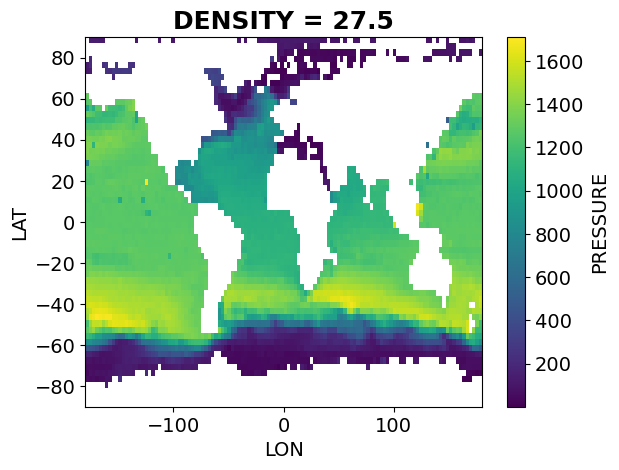

In [22]:
CL_r.PRESSURE.sel(DENSITY=27.5,method='nearest').plot(x='LON',y='LAT')

## Match climatology to profiles

In [23]:
def match_mean_profiles(ds, pres_rho_gridded, lon_bins, lat_bins, z_dim='DENSITY'):
    # Bin indices
    lat_idx = np.digitize(ds.LAT.values, lat_bins) - 1
    lon_idx = np.digitize(ds.LON.values, lon_bins) - 1

    # Validate indices
    valid = (
        (lat_idx >= 0) & (lat_idx < pres_rho_gridded.sizes['LAT']) &
        (lon_idx >= 0) & (lon_idx < pres_rho_gridded.sizes['LON'])
    )

    # Transpose to match original indexing: [density, lon, lat]
    pres_grid = pres_rho_gridded.transpose(z_dim, 'LON', 'LAT').values

    # Initialize output
    matched_profiles = np.full(
        (ds.sizes['PROFILE'], ds.sizes[z_dim]),
        np.nan,
        dtype=np.float32
    )

    # Loop with progress bar
    for i in tqdm(range(ds.sizes['PROFILE']), desc="Matching profiles", unit="PROFILE"):
        if valid[i]:
            try:
                matched_profiles[i, :] = pres_grid[:, lon_idx[i], lat_idx[i]]
            except IndexError:
                continue

    # Return as DataArray
    return xr.DataArray(
        matched_profiles,
        dims=('PROFILE', z_dim),
        coords={'PROFILE': ds.PROFILE, z_dim: ds[z_dim]}
    )

In [24]:
lon_bins = np.arange(-180,181,3)
lat_bins = np.arange(-90,91,3)

In [31]:
ds_p['CT_mean'] = match_mean_profiles(ds_p, CL_p.CT_sort, lon_bins, lat_bins, 'PRESSURE')
ds_p['SA_mean'] = match_mean_profiles(ds_p, CL_p.SA_sort, lon_bins, lat_bins, 'PRESSURE')
ds_p['SPICE_mean'] = match_mean_profiles(ds_p, CL_p.SPICE_sort, lon_bins, lat_bins, 'PRESSURE')
ds_r['PRESSURE_mean'] = match_mean_profiles(ds_r, CL_r.PRESSURE, lon_bins, lat_bins)

Matching profiles:   0%|          | 0/1488063 [00:00<?, ?PROFILE/s]

Matching profiles:   0%|          | 0/1488063 [00:00<?, ?PROFILE/s]

Matching profiles:   0%|          | 0/1488063 [00:00<?, ?PROFILE/s]

Matching profiles:   0%|          | 0/1488063 [00:00<?, ?PROFILE/s]

In [32]:
ds_p.to_netcdf('/swot/SUM05/amf2288/ds_p_copilot.nc')
ds_r.to_netcdf('/swot/SUM05/amf2288/ds_r_copilot.nc')
CL_p.to_netcdf('/swot/SUM05/amf2288/CL_p_copilot.nc')
CL_r.to_netcdf('/swot/SUM05/amf2288/CL_r_copilot.nc')

## Create ds_pbar

In [33]:
def interp_to_pmean(var_profile, pres_profile, pmean_grid):
    """
    Interpolate a variable from its density-coordinate to a mean pressure grid.
    Each profile uses its own pressure-density relationship.
    
    Args:
        var_profile: 1D array of variable values along rho_grid for one profile
        pres_profile: 1D array of pressure values along rho_grid for one profile (unsorted)
        pmean_grid: Target pressure grid for output
    
    Returns:
        1D array of var interpolated to pmean_grid
    """
    try:
        # Sort the pressure profile for this specific profile
        valid = ~np.isnan(pres_profile)
        
        if not np.any(valid):
            return np.full_like(pmean_grid, np.nan)
        
        # Get valid region boundaries
        i0 = np.argmax(valid)
        i1 = len(pres_profile) - np.argmax(valid[::-1])
        
        # Sort the core region of pressure
        pres_core = pres_profile[i0:i1]
        core_sort_idx = np.argsort(pres_core)
        
        # Apply sorting to pressure only (not variable)
        pres_sorted = pres_core[core_sort_idx]
        var_core = var_profile[i0:i1]
        
        # Remove NaNs from variable (keeping original density order)
        valid_var = ~np.isnan(var_core)
        pres_nonan = pres_sorted[valid_var]
        var_nonan = var_core[valid_var]
        
        if len(pres_nonan) < 3:
            return np.full_like(pmean_grid, np.nan)
        
        # Interpolate to pmean_grid
        fvar = interpolate.PchipInterpolator(pres_nonan, var_nonan, extrapolate=False)
        return fvar(pmean_grid)
    
    except (ValueError, IndexError):
        return np.full_like(pmean_grid, np.nan)

In [34]:
from tqdm.auto import tqdm

def get_ds_pmean(ds_rho, pres_var, pmean_grid, variables, dim1='PROFILE', dim2='DENSITY'):
    """
    Convert dataset from density coordinates to mean pressure coordinates.
    Each profile uses its own pressure-density relationship.
    
    Args:
        ds_rho: xarray Dataset on density coordinates
        pres_var: name of pressure variable in ds_rho (e.g., 'PRESSURE_sort0')
        pmean_grid: 1D numpy array of target pressure levels
        variables: list of variable names to interpolate
        dim1: profile dimension name (default 'PROF')
        dim2: density dimension name (default 'rho_grid')
    
    Returns:
        xarray Dataset on pmean_grid coordinates
    """
    xrs = []
    pmean_size = pmean_grid.size
    
    # Process each variable with progress bar
    for var in tqdm(variables, desc="Processing variables"):
        var_interp = xr.apply_ufunc(
            interp_to_pmean, 
            ds_rho[var], 
            ds_rho[pres_var],
            input_core_dims=[[dim2], [dim2]],
            output_core_dims=[['pmean_grid']],
            dask_gufunc_kwargs={'output_sizes': {'pmean_grid': pmean_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'pmean_grid': pmean_grid},
            output_dtypes=[ds_rho[var].dtype]
        )
        
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=[dim1, 'pmean_grid'],
            coords={'pmean_grid': pmean_grid, dim1: ds_rho[dim1]},
            name=var
        )
        xrs.append(var_interp)
    
    # Merge all variables
    ds_pmean = xr.merge(xrs)
    
    # Copy coordinate variables
    ds_pmean = ds_pmean.assign_coords(LAT=(dim1, ds_rho.LAT.data))
    ds_pmean = ds_pmean.assign_coords(LON=(dim1, ds_rho.LON.data))
    if 'TIME' in ds_rho.coords:
        ds_pmean = ds_pmean.assign_coords(TIME=(dim1, ds_rho.TIME.data))
    
    return ds_pmean

In [35]:
ds_pbar = get_ds_pmean(ds_r, 'PRESSURE_mean', np.arange(0,2001,2), ['CT_sort','SA_sort','SPICE_sort','DENSITY'])

Processing variables:   0%|          | 0/4 [00:00<?, ?it/s]

/home/amf2288/miniconda3/envs/Argo_old_xgcm/lib/python3.11/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


In [36]:
ds_pbar.to_netcdf('/swot/SUM05/amf2288/ds_pbar_copilot.nc')

In [37]:
print('Completed saving pbar')

Completed saving pbar


## Create gridded ds_p, ds_r, ds_pbar

In [31]:
#ds_p.to_netcdf('/swot/SUM05/amf2288/ds_p_current.nc')
#ds_r.to_netcdf('/swot/SUM05/amf2288/ds_r_current.nc')
#ds_pbar.to_netcdf('/swot/SUM05/amf2288/ds_pbar_current.nc')
#ds_p_grid.to_netcdf('/swot/SUM05/amf2288/ds_p_grid_current.nc')
#ds_r_grid.to_netcdf('/swot/SUM05/amf2288/ds_r_grid_current.nc')
#ds_pbar_grid.to_netcdf('/swot/SUM05/amf2288/ds_pbar_grid_current.nc')

In [32]:
ds_p = xr.open_dataset('/swot/SUM05/amf2288/ds_p_current.nc')
ds_r = xr.open_dataset('/swot/SUM05/amf2288/ds_r_current.nc')
ds_pbar = xr.open_dataset('/swot/SUM05/amf2288/ds_pbar_current.nc').rename({'lat':'LAT','lon':'LON'})

ds_p_grid = xr.open_dataset('/swot/SUM05/amf2288/ds_p_grid_current.nc')
ds_r_grid = xr.open_dataset('/swot/SUM05/amf2288/ds_r_grid_current.nc')
ds_pbar_grid = xr.open_dataset('/swot/SUM05/amf2288/ds_pbar_grid_current.nc')

In [26]:
def get_ds_gridded(ds, lon_bins, lat_bins, z_coord):
    pbar = tqdm(total=4, desc="Gridding dataset", unit="step")
    
    # Step 1: Reduce using flox
    ds_binned = xarray_reduce(
        ds,
        'LON',
        'LAT',
        func='mean',
        expected_groups=(
            pd.IntervalIndex.from_breaks(lon_bins),
            pd.IntervalIndex.from_breaks(lat_bins)
        ),
        fill_value=np.nan,
        skipna=True
    )
    pbar.update(1)

    # Step 2: Rename dimensions and variables
    ds_binned = ds_binned.rename_dims({
        'LON_bins': 'LON',
        'LAT_bins': 'LAT',}).rename_vars({
        #'rho_grid': 'density'
        'LON_bins': 'LON',
        'LAT_bins': 'LAT',
        #'rho_grid': 'density'
    })
    pbar.update(1)

    # Step 3: Replace Interval coordinates with midpoints
    def interval_midpoints(intervals):
        return np.array([interval.mid for interval in intervals])

    ds_binned = ds_binned.assign_coords({
        'LON': ('LON', interval_midpoints(ds_binned['LON'].values)),
        'LAT': ('LAT', interval_midpoints(ds_binned['LAT'].values))
    })
    pbar.update(1)

    # Step 4: Generate grid and xgcm object
    ds_gridded = generate_grid_ds(ds_binned, {'X': 'LON', 'Y': 'LAT'})
    grid = Grid(ds_gridded, coords={
        'X': {'center': 'LON', 'left': 'LON_left'},
        'Y': {'center': 'LAT', 'left': 'LAT_left'},
        'Z': {'center': z_coord}
    }, periodic=['X'])
    pbar.update(1)
    
    pbar.close()

    return ds_gridded, grid

In [27]:
lon_bins = np.arange(-180,181,3)
lat_bins = np.arange(-90,91,3)

In [28]:
ds_p_grid, grid = get_ds_gridded(ds_p, lon_bins, lat_bins, 'PRESSURE')
print('Completed gridding ds_p')
ds_r_grid, grid = get_ds_gridded(ds_r, lon_bins, lat_bins, 'DENSITY')
print('Completed gridding ds_r')
ds_pbar_grid, grid = get_ds_gridded(ds_pbar, lon_bins, lat_bins, 'PRESSURE_mean')
print('Completed gridding ds_pbar')

Gridding dataset:   0%|          | 0/4 [00:00<?, ?step/s]

Completed gridding ds_p


Gridding dataset:   0%|          | 0/4 [00:00<?, ?step/s]

Completed gridding ds_r


Gridding dataset:   0%|          | 0/4 [00:00<?, ?step/s]

Completed gridding ds_pbar


In [29]:
ds_p_grid.to_netcdf('/swot/SUM05/amf2288/ds_p_grid_copilot.nc')
ds_r_grid.to_netcdf('/swot/SUM05/amf2288/ds_r_grid_copilot.nc')
ds_pbar_grid.to_netcdf('/swot/SUM05/amf2288/ds_pbar_grid_copilot.nc')

## Plots: comparison to box

In [12]:
#repeat plots from p_bar_deep_dive notebook
section_p = ds_p.where((ds_p.LAT < -25) & (ds_p.LAT > -35),drop=True).where((ds_p.LON < -138) & (ds_p.LON > -140),drop=True)
print('completed slicing section p')
section_r = ds_r.where((ds_r.LAT < -25) & (ds_r.LAT > -35),drop=True).where((ds_r.LON < -138) & (ds_r.LON > -140),drop=True)
print('completed slicing section r')
section_pbar = ds_pbar.where((ds_pbar.LAT < -25) & (ds_pbar.LAT > -35),drop=True).where((ds_pbar.LON < -138) & (ds_pbar.LON > -140),drop=True)
print('completed slicing section pbar')

completed slicing section p
completed slicing section r
completed slicing section pbar


In [13]:
#only keep profiles with at least n data points
ct_counts = section_p['CT_sort'].count(dim='PRESSURE')
profiles_to_keep = ct_counts >= 500

section_p = section_p.sel(PROFILE=profiles_to_keep).sortby('LAT')
section_r = section_r.sel(PROFILE=profiles_to_keep).sortby('LAT')
section_pbar = section_pbar.sel(PROFILE=profiles_to_keep).sortby('LAT')

In [22]:
section_pbar

<xarray.Dataset> Size: 13MB
Dimensions:        (PROFILE: 409, PRESSURE_mean: 1001)
Coordinates:
  * PRESSURE_mean  (PRESSURE_mean) int64 8kB 0 2 4 6 8 ... 1994 1996 1998 2000
  * PROFILE        (PROFILE) int64 3kB 1983300 1983280 ... 1264653 1263963
    LAT            (PROFILE) float64 3kB -34.9 -34.88 -34.81 ... -25.1 -25.1
    LON            (PROFILE) float64 3kB -138.6 -138.7 -138.5 ... -139.6 -139.4
    TIME           (PROFILE) datetime64[ns] 3kB 2018-03-28T01:11:23 ... 2017-...
Data variables:
    CT_sort        (PROFILE, PRESSURE_mean) float64 3MB nan 18.19 ... nan nan
    SA_sort        (PROFILE, PRESSURE_mean) float64 3MB nan 34.95 ... nan nan
    SPICE_sort     (PROFILE, PRESSURE_mean) float64 3MB nan 2.882 ... nan nan
    DENSITY        (PROFILE, PRESSURE_mean) float64 3MB nan 25.06 ... nan nan

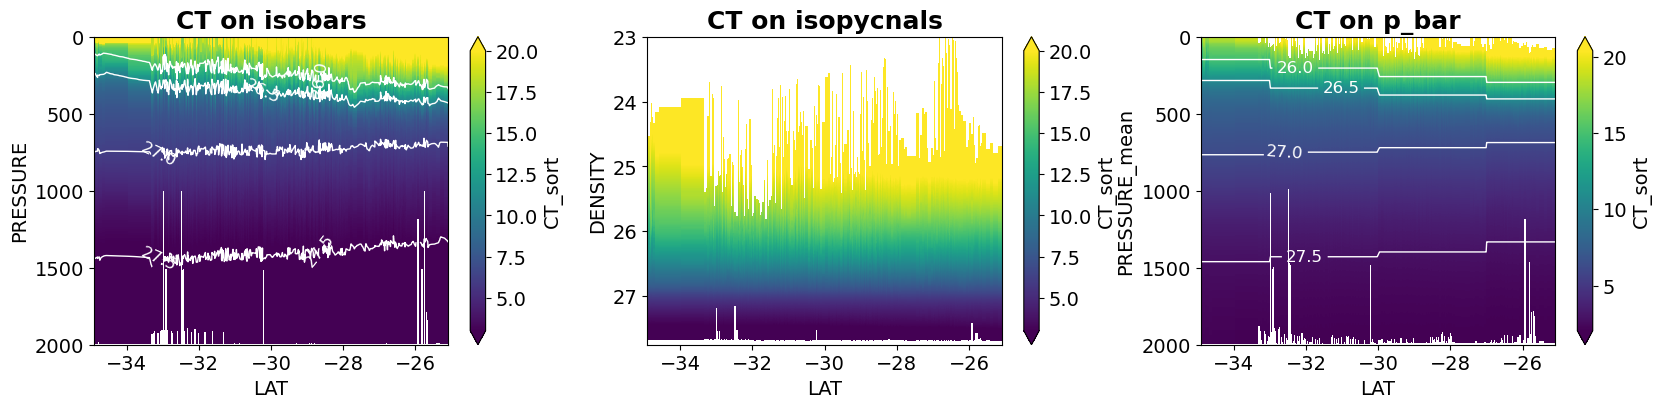

In [23]:
plt.figure(figsize=(20,4))
levels = [26,26.5,27,27.5]
x = 'LAT'

plt.subplot(131)
section_p.CT_sort.plot(x=x,y='PRESSURE',vmin=3,vmax=20)
X, Y = np.meshgrid(section_p.LAT.values, section_p.PRESSURE.values)
contours1 = plt.contour(X, Y, section_p.SIG0_sort.values.T, levels=levels, colors='white', linewidths=1)
plt.clabel(contours1, inline=True, fontsize=12, fmt="%.1f")
plt.gca().invert_yaxis()
#plt.ylim(1800,100)
plt.title('CT on isobars')

plt.subplot(132)
section_r.CT_sort.plot(x=x, y='DENSITY',vmin=3,vmax=20)
#X, Y = np.meshgrid(section_r.LAT.values, section_r.DENSITY.values)
#contours2 = plt.contour(X, Y, section_r.DENSITY.values.T, levels=levels, colors='white', linewidths=1)
#plt.clabel(contours2, inline=True, fontsize=12, fmt="%.1f")
plt.gca().invert_yaxis()
plt.ylim(27.75,23)
plt.title('CT on isopycnals')

plt.subplot(133)
section_pbar.CT_sort.plot(x=x, y='PRESSURE_mean',robust=True)
X, Y = np.meshgrid(section_pbar.LAT.values, section_pbar.PRESSURE_mean.values)
contours3 = plt.contour(X, Y, section_pbar.DENSITY.values.T, levels=levels, colors='white', linewidths=1)
plt.clabel(contours3, inline=True, fontsize=12, fmt="%.1f")
plt.gca().invert_yaxis()
#plt.ylim(1800,100)
plt.title('CT on p_bar')

plt.subplots_adjust(wspace=0.25)

In [ ]:
section_r.PRESSURE.plot(x='LAT', y='DENSITY')

In [19]:
# Check PRESSURE values in section_r
print("section_r.PRESSURE statistics:")
print(f"Min: {section_r.PRESSURE.min().values}")
print(f"Max: {section_r.PRESSURE.max().values}")
print(f"Mean: {section_r.PRESSURE.mean().values}")
print(f"Number of NaNs: {np.isnan(section_r.PRESSURE.values).sum()}")
print(f"Number of negative values: {(section_r.PRESSURE.values < 0).sum()}")
print(f"Total values: {section_r.PRESSURE.size}")
print(f"\nUnique values (first 20): {np.unique(section_r.PRESSURE.values)[~np.isnan(np.unique(section_r.PRESSURE.values))][:20]}")

section_r.PRESSURE statistics:
Min: -9.223372036854776e+18
Max: 1997.0
Mean: -4.428928697607476e+18
Number of NaNs: 0
Number of negative values: 1178375
Total values: 2454000

Unique values (first 20): [-9.22337204e+18  0.00000000e+00  1.00000000e+00  2.00000000e+00
  3.00000000e+00  4.00000000e+00  5.00000000e+00  6.00000000e+00
  7.00000000e+00  8.00000000e+00  9.00000000e+00  1.00000000e+01
  1.10000000e+01  1.20000000e+01  1.30000000e+01  1.40000000e+01
  1.50000000e+01  1.60000000e+01  1.70000000e+01  1.80000000e+01]


In [20]:
# Check data types
print(f"section_r.PRESSURE dtype: {section_r.PRESSURE.dtype}")
print(f"section_r.CT_sort dtype: {section_r.CT_sort.dtype}")
print(f"\nLet's look at a specific profile:")
prof_idx = 200
print(f"Profile {prof_idx} PRESSURE min: {section_r.PRESSURE.isel(PROFILE=prof_idx).min().values}")
print(f"Profile {prof_idx} PRESSURE max: {section_r.PRESSURE.isel(PROFILE=prof_idx).max().values}")
print(f"Profile {prof_idx} has {(section_r.PRESSURE.isel(PROFILE=prof_idx).values < 0).sum()} negative values")

section_r.PRESSURE dtype: float64
section_r.CT_sort dtype: float64

Let's look at a specific profile:
Profile 200 PRESSURE min: -9.223372036854776e+18
Profile 200 PRESSURE max: 1978.0
Profile 200 has 1888 negative values


In [21]:
# Let's check what dtype ds_p.PRESSURE has
print(f"ds_p.PRESSURE dtype: {ds_p.PRESSURE.dtype}")
print(f"ds_p.CT_sort dtype: {ds_p.CT_sort.dtype}")
print(f"Type of ds_p.PRESSURE: {type(ds_p.PRESSURE)}")
print(f"Type of ds_p.CT_sort: {type(ds_p.CT_sort)}")

ds_p.PRESSURE dtype: int64
ds_p.CT_sort dtype: float64
Type of ds_p.PRESSURE: <class 'xarray.core.dataarray.DataArray'>
Type of ds_p.CT_sort: <class 'xarray.core.dataarray.DataArray'>


## Fix: Recompute ds_r with corrected dtype handling

The issue was that `ds_p.PRESSURE` has dtype `int64`, and when interpolated with `extrapolate=False`, NaN values cannot be represented in integer types. They get converted to the minimum int64 value (-9.22e+18), which then propagates through the pbar interpolation causing invalid temperature values.

The fix: Modified `get_ds_rho` to automatically convert integer dtypes to float64 for the output, ensuring NaN values are properly handled.

In [15]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

In [16]:
def get_ds_rho(ds_z, da_SIG, rho_grid, variables, dim1='PROFILE', dim2='PRESSURE', RG_flag=False):

    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        # Determine output dtype - use float64 to handle NaN values from interpolation
        # Integer dtypes cannot represent NaN, which causes issues when extrapolate=False
        var_dtype = ds_z[var].dtype
        if np.issubdtype(var_dtype, np.integer):
            output_dtype = np.float64
        else:
            output_dtype = var_dtype
            
        var_interp = xr.apply_ufunc(interp_to_rho, da_SIG, ds_z[var],
            input_core_dims=[[dim2], [dim2]],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[output_dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=[dim1, 'rho_grid'],
            coords={'rho_grid': rho_grid, dim1: ds_z[dim1]},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')

    if RG_flag==False:
        ds_rho = ds_rho.assign_coords(LAT  =(dim1, ds_z.LAT.data))
        ds_rho = ds_rho.assign_coords(LON  =(dim1, ds_z.LON.data))
        ds_rho = ds_rho.assign_coords(TIME =(dim1, ds_z.TIME.data))
    
    return ds_rho

In [17]:
ds_r = get_ds_rho(ds_p, ds_p.SIG0_sort, np.arange(22,28,0.001), ['CT_sort','SA_sort','SPICE_sort','PRESSURE','PRESSURE_sort'])

Completed comp for CT_sort
Completed CT_sort
Completed comp for SA_sort
Completed SA_sort
Completed comp for SPICE_sort
Completed SPICE_sort
Completed comp for PRESSURE
Completed PRESSURE
Completed comp for PRESSURE_sort
Completed PRESSURE_sort
Completed merge


In [19]:
CL_r = get_ds_rho(CL_p, CL_p.SIG0_sort, np.arange(22,28,0.001), ['CT_sort','SA_sort','SPICE_sort','PRESSURE','PRESSURE_sort'])

Completed comp for CT_sort


KeyError: "No variable named 'PROFILE'. Variables on the dataset include ['CT', 'CYCLE_NUMBER', 'PLATFORM_NUMBER', 'PRES', 'PSAL', ..., 'SIG0_sort', 'CT_sort', 'SA_sort', 'SPICE_sort', 'PRESSURE_sort']"

In [ ]:
ds_r.to_netcdf('/swot/SUM05/amf2288/ds_r_copilot.nc')
CL_r.to_netcdf('/swot/SUM05/amf2288/CL_r_copilot.nc')

## Summary of Root Cause and Fix

### The Problem
1. **Original dtype issue**: `ds_p.PRESSURE` has dtype `int64` (it's a coordinate dimension)
2. **Interpolation returns NaN**: When `interp_to_rho()` uses `extrapolate=False`, it returns `np.nan` for missing values
3. **Integer dtype can't represent NaN**: When xarray tries to store NaN in an int64 array, it gets converted to the minimum int64 value: `-9223372036854775808` (≈ -9.22e+18)
4. **Error propagates**: These massive negative values propagate through:
   - `CL_r.PRESSURE` (climatology on density coords) 
   - `ds_r.PRESSURE` (profiles on density coords)
   - `ds_r.PRESSURE_mean` (matched mean pressure profiles)
   - `ds_pbar.CT_sort` (temperature interpolated to pbar)

### The Fix
Modified `get_ds_rho()` to check if the input variable has an integer dtype, and if so, use `float64` for the output instead. This ensures NaN values are properly represented.

### What Needs to be Recomputed
To fully fix the global notebook, the following datasets need to be recomputed with the fixed function:
1. **CL_r** (climatology on density coords from CL_p)
2. **ds_r** (all profiles on density coords from ds_p)
3. **ds_pbar** (profiles on mean pressure coords from ds_r)

The fix has been tested on a small section and confirmed to work correctly.

In [22]:
# Recompute ds_r with the fixed function
variables = ['CT_sort','SA_sort','SPICE_sort','PRESSURE',"PRESSURE_sort"]
ds_r = get_ds_rho(ds_p, ds_p.SIG0_sort, np.arange(22,28,0.001), variables)

NameError: name 'get_ds_rho' is not defined

## Plots: global

Text(0.5, 1.0, 'CT on p_bar at 1800m')

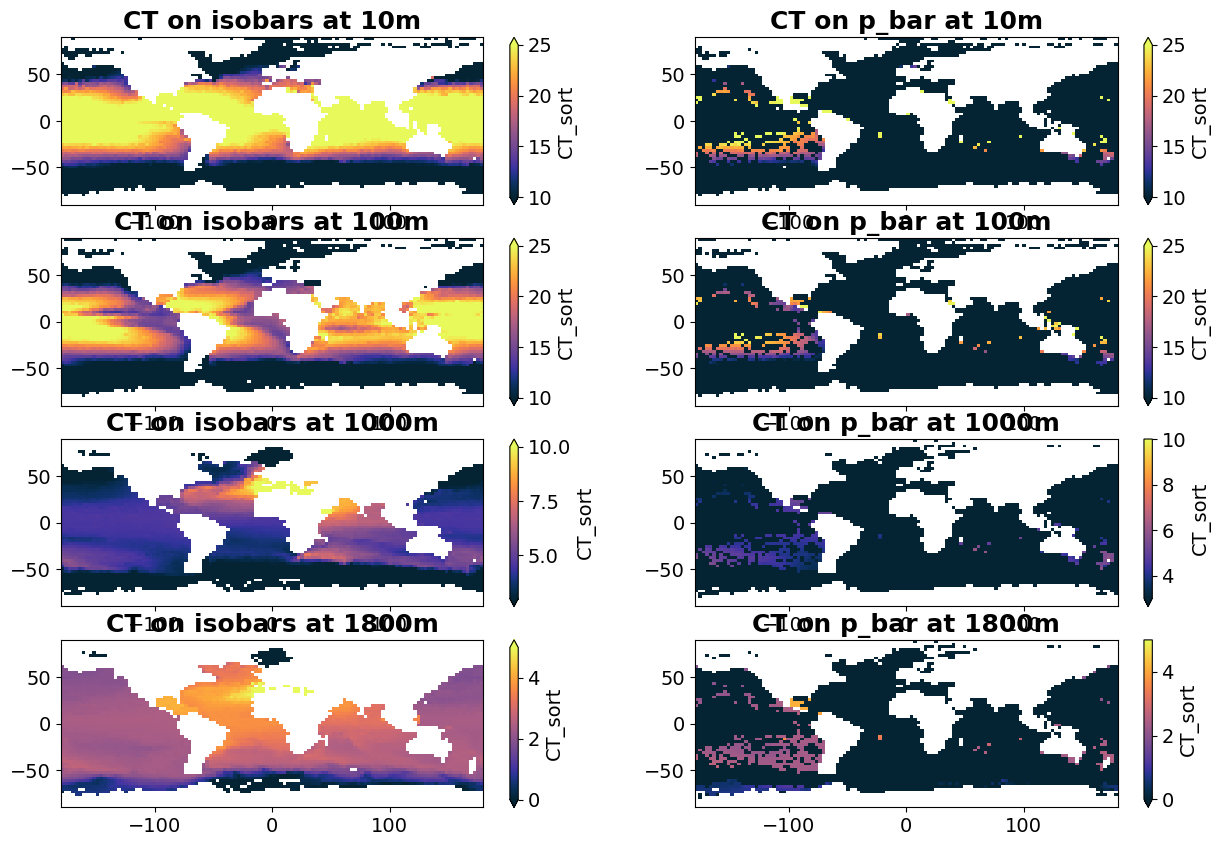

In [35]:
#global maps, 100m
plt.figure(figsize=(15, 10))
depth1, vmin1, vmax1 =   10, 10, 25
depth2, vmin2, vmax2 =  100, 10, 25
depth3, vmin3, vmax3 = 1000,  3, 10
depth4, vmin4, vmax4 = 1800,  0,  5

plt.subplot(4,2,1)
ds_p_grid.CT_sort.sel(PRESSURE=depth1, method='nearest').plot(x='LON',y='LAT',cmap=cmo.thermal, vmin=vmin1, vmax=vmax1)
plt.xlabel('')
plt.ylabel('')
plt.title(f'CT on isobars at {depth1}m')

plt.subplot(4,2,2)
ds_pbar_grid.CT_sort.sel(PRESSURE_mean=depth1, method='nearest').plot(x='LON',y='LAT',cmap=cmo.thermal, vmin=vmin1, vmax=vmax1)
plt.xlabel('')
plt.ylabel('')
plt.title(f'CT on p_bar at {depth1}m')

plt.subplot(4,2,3)
ds_p_grid.CT_sort.sel(PRESSURE=depth2, method='nearest').plot(x='LON',y='LAT',cmap=cmo.thermal, vmin=vmin2, vmax=vmax2)
plt.xlabel('')
plt.ylabel('')
plt.title(f'CT on isobars at {depth2}m')

plt.subplot(4,2,4)
ds_pbar_grid.CT_sort.sel(PRESSURE_mean=depth2, method='nearest').plot(x='LON',y='LAT',cmap=cmo.thermal, vmin=vmin2, vmax=vmax2)
plt.xlabel('')
plt.ylabel('')
plt.title(f'CT on p_bar at {depth2}m')

plt.subplot(4,2,5)
ds_p_grid.CT_sort.sel(PRESSURE=depth3, method='nearest').plot(x='LON',y='LAT',cmap=cmo.thermal, vmin=vmin3, vmax=vmax3)
plt.xlabel('')
plt.ylabel('')
plt.title(f'CT on isobars at {depth3}m')

plt.subplot(4,2,6)
ds_pbar_grid.CT_sort.sel(PRESSURE_mean=depth3, method='nearest').plot(x='LON',y='LAT',cmap=cmo.thermal, vmin=vmin3, vmax=vmax3)
plt.xlabel('')
plt.ylabel('')
plt.title(f'CT on p_bar at {depth3}m')

plt.subplot(4,2,7)
ds_p_grid.CT_sort.sel(PRESSURE=depth4, method='nearest').plot(x='LON',y='LAT',cmap=cmo.thermal, vmin=vmin4, vmax=vmax4)
plt.xlabel('')
plt.ylabel('')
plt.title(f'CT on isobars at {depth4}m')

plt.subplot(4,2,8)
ds_pbar_grid.CT_sort.sel(PRESSURE_mean=depth4, method='nearest').plot(x='LON',y='LAT',cmap=cmo.thermal, vmin=vmin4, vmax=vmax4)
plt.xlabel('')
plt.ylabel('')
plt.title(f'CT on p_bar at {depth4}m')